BDS^3
=====

## Quantitative microscopy
#### Reconstruction of proteins' biophysical properties with live-cell imaging data
---
_Borys Olifirov, 07.2023, Uzhhorod_

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology

from scipy.ndimage import measurements
from scipy import signal

## 1. Biophysical properties of calcium ions binding process

#### One ligand binding. Langmuir equation

Second-order reaction equation of the one ligand __L__ binding with protein __P__:
$$
P + L \rightleftharpoons PL
$$

The total concentrations of protein (__[P]0__) and ligand (__[L]0__) are composed of the concentrations of their respective free (__[P]__, __[L]__) and bound (__[PL]__) forms:
$$
[P]_0 = [P] + [PL] \\
[L]_0 = [L] + [PL]
$$


$$
K_d = \frac{[P] \cdot [L]}{[PL]}
$$




In terms of the fraction of bound protein __Y__ we can rewrite the equation:
$$
Y = \frac{[PL]}{[P]_0}

$$

           Cₗ  
Y(Cₗ) = ───────
        Cₗ + Kₐ


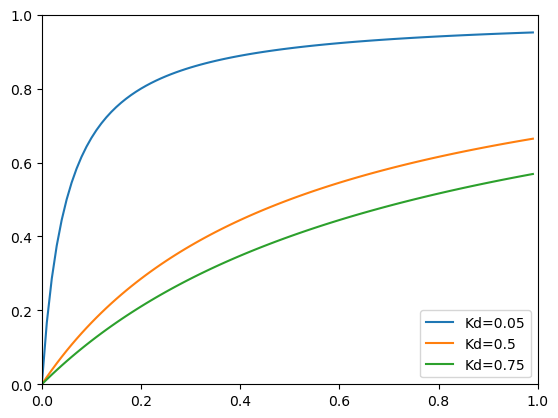

In [2]:
import sympy as sp

Kd_1 = 0.05
Kd_2 = 0.5
Kd_3 = 0.75

c = np.arange(0, 1, 0.01)

K_d, C_L = sp.symbols('K_a, C_l')
Y = sp.Function('Y')(C_L)
lang_eq = sp.Eq(Y, C_L/(C_L + K_d))

sp.pprint(lang_eq)

lang_eq_sol_Kd_1 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_1}).rhs, 'numpy') 
lang_eq_sol_Kd_2 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_2}).rhs, 'numpy') 
lang_eq_sol_Kd_3 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_3}).rhs, 'numpy') 

plt.plot(c, lang_eq_sol_Kd_1(c), label=f'Kd={Kd_1}')
plt.plot(c, lang_eq_sol_Kd_2(c), label=f'Kd={Kd_2}')
plt.plot(c, lang_eq_sol_Kd_3(c), label=f'Kd={Kd_3}')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()


#### Multiple ligands binding & cooperativity. Hill equation

$$
[P]_0 \\
[L]_0 \\


X=0
$$

In [ ]:


def hill_fam(K_val, n_list, c=np.arange(0, 1, 0.01)):
	""" Hill equation solutions family.

	"""
	n, K_A, C_ca = sp.symbols('n  K_a C_ion')
	Y = sp.Function('Y')(C_ca)
	hill_eq = sp.Eq(Y, C_ca**n/(K_A**n + C_ca**n))
	hill_sol_assemblage = [sp.lambdify(C_ca, hill_eq.subs({n : n_val, K_A : K_val}).rhs, "numpy") for n_val in n_list]

	sp.pprint(hill_eq, use_unicode=True)

	fig, ax = plt.subplots(figsize=(4, 4))
	plt.subplot()
	for i in range(0, len(hill_sol_assemblage)):
		plt.plot(c, hill_sol_assemblage[i](c), label=f'n={n_list[i]}')
	plt.xlabel('C')
	plt.ylabel('Y')
	plt.legend()
	plt.show()
	
hill_fam(K_val=0.5, n_list=[1, 2, 3, 4])  # np.arange(1, 6, 1)

## 2. Multidimensional arrays & structure of microscopic data 

## 3. Filters, masks and morphology operations

## 4. Cell detection and segmentation

## 5. 

## 6.

In [ ]:
img_raw = io.imread('post_rgeco_mov_cor.tif')
img_bad = io.imread('post_rgeco.tif')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_bad, axis=0), cmap='jet')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_raw, axis=0), cmap='jet')

img = np.array([filters.gaussian(frame) for frame in img_raw])

print(img.shape)

In [ ]:
th_y = filters.threshold_yen(np.max(img, axis=0))
th_o = filters.threshold_otsu(np.max(img, axis=0))
th_l = filters.threshold_li(np.max(img, axis=0))

print(th_y, th_o, th_l)


img_max = np.max(img, axis=0)
plt.figure(figsize=(10,10))
plt.imshow(img_max, cmap='jet')

mask = img_max > th_y
crop_mask = mask[100:200, 100:200]
plt.figure(figsize=(10,10))
plt.imshow(mask)

label_mask = measure.label(mask)
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap='jet')

In [ ]:
area_dict = {}
area_th = 150
for label_number in range(1, np.max(label_mask)):
    one_label_mask = label_mask == label_number
    one_label_area = np.sum(one_label_mask)
    
    if one_label_area >= area_th:
        label_area_dict = {label_number:one_label_area}
        area_dict.update(label_area_dict)

fin_mask = np.zeros_like(label_mask)
for lable_key in area_dict.keys():
     key_mask = label_mask == lable_key
     fin_mask = fin_mask + key_mask

fin_raw_mask = fin_mask
fin_mask = morphology.dilation(fin_mask, footprint=morphology.disk(6))
# plt.imshow(fin_raw_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)


fin_mask = measure.label(fin_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)

#### Watershed segmentation

In [ ]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_cdt(fin_mask, metric='taxicab')
plt.figure(figsize=(10,10))
plt.imshow(distance)

# ndi.distance_transform_cdt, metric='taxicab'

coords = peak_local_max(distance, min_distance=15, footprint=morphology.disk(15), labels=fin_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=fin_mask)

plt.figure(figsize=(10,10))
plt.imshow(labels)

#### Profiles extration

In [ ]:
# profile = [np.mean(ma.masked_where(-fin_mask, frame)) for frame in img_raw]

plt.figure(figsize=(20, 8))

prof_arr = []
i = 0
for label in range(1, np.max(labels)+1):
    mask = labels == label
    prof = [np.mean(ma.masked_where(~mask, frame)) for frame in img_raw]
    prof_arr.append(prof)
    plt.plot(prof, label=label)
    i += 200

plt.legend()
plt.show()

prof_arr = np.asarray(prof_arr)

print(prof_arr.shape)


#### Demo labeling

In [ ]:
demo_mask = np.array([[1, 0, 1, 0],
                      [0, 0, 1, 1],
                      [0, 1, 0, 0],
                      [1, 0, 1, 0]])

label_demo_mask = measure.label(demo_mask, connectivity=1)

print(demo_mask)
print(label_demo_mask)
plt.imshow(label_demo_mask)

# Profile an

#### dF/F calc

In [ ]:
dF_prof_arr = []
for prof in prof_arr:
    F_0 = np.mean(prof[0:50])
    dF_prof = (prof - F_0)/F_0
    dF_prof_arr.append(dF_prof)

dF_prof_arr = np.asarray(dF_prof_arr)
plt.figure(figsize=(20, 8))
for dF_p in dF_prof_arr:
    plt.plot(dF_p)
plt.show()    
    
    

#### Peaks detection

In [ ]:
one_profile = dF_prof_arr[2]

peaks, properties = signal.find_peaks(one_profile,
                                      height=0.2,
                                      distance=5,
                                      wlen=30,
                                      prominence=0.15,
                                      rel_height=0.5,
                                      width=1)

print(peaks)
print(properties.keys())
print(properties)

In [ ]:

plt.figure(figsize=(20, 8))
plt.plot(one_profile)
plt.plot(peaks, one_profile[peaks], 'x')
